In [1]:
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ki67.interfaces.cells import Cells

In [2]:
sns.set_theme(style="whitegrid")

In [4]:
with open('./data/experiments/config.json') as fp:
    config = json.load(fp)

amy_slides = config['shards']['amy']
ben_slides = config['shards']['ben']
charlie_slides = config['shards']['charlie']
testing_slides = config['testing']

In [5]:
def process_slide(slide: str, model: str):
    markers = pd.read_parquet(f'data/results/{slide}/markers.gz.parquet')
    gt_ki = len(markers[markers.type == 1]) / len(markers)

    cells = Cells.parse(slide, np.load(f'data/results/{slide}/th-training.npz'))
    positive_area = np.sum(cells.data[cells.CellType.POSITIVE].mask)
    cumulative_area = np.sum(cells.data[cells.CellType.ALL].mask)

    ki = positive_area / cumulative_area if cumulative_area > 0 else np.NaN
    return pd.Series(dict(
        slide=slide,
        model=model,
        gt=gt_ki,
        ki=ki,
        th_positive=cells.data[cells.CellType.POSITIVE].threshold,
        th_all=cells.data[cells.CellType.ALL].threshold,
        error=gt_ki - ki,
        delta=np.abs(gt_ki - ki),
    ), name=slide)

In [6]:
amy_training = pd.DataFrame([process_slide(s, 'amy') for s in ben_slides + charlie_slides])
ben_training = pd.DataFrame([process_slide(s, 'ben') for s in amy_slides + charlie_slides])
charlie_training = pd.DataFrame([process_slide(s, 'charlie') for s in amy_slides + ben_slides])
ensemble_training = pd.DataFrame([process_slide(s, 'ensemble') for s in amy_slides + ben_slides + charlie_slides])

training_data = pd.concat([amy_training, ben_training, charlie_training, ensemble_training])

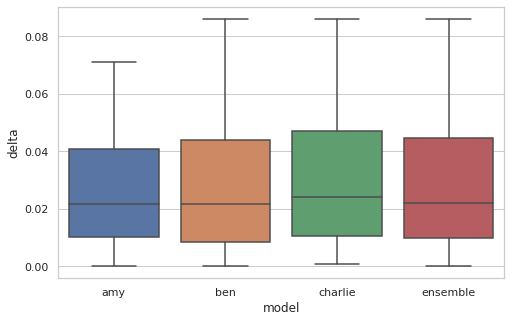

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x="model", y="delta", data=training_data, showfliers=False, ax=ax)
None

In [9]:
def calculate_ths(df, name, level=0.05):
    df = df[df.delta <= level]
    return pd.Series(dict(
        accepted=len(df),
        positive=df.th_positive.mean(),
        relevant=df.th_all.mean(),
    ), name=name)

shards = pd.DataFrame([
    calculate_ths(shard, name)
    for shard, name in [
        (amy_training, 'amy'),
        (ben_training, 'ben'),
        (charlie_training, 'charlie'),
        (ensemble_training, 'ensemble'),
    ]
])

shards.to_csv('./data/experiments/thresholds.csv')
shards

,accepted,positive,relevant
amy,41.0,0.442525,0.371137
ben,41.0,0.447491,0.366678
charlie,38.0,0.450048,0.365586
ensemble,60.0,0.446604,0.367856
